# Assignment 7 -- Bayesian inference (Gaussian distributions)
Follwing our steps in the lecture, implement a curve fitting model using a superposition of radial basis functions (RBFs):
$$
    g(x, w, \mu) = \sum_{i=1}^M w_i \exp \left(-\frac{1}{2} \left(\frac{x - \mu_i}{s}\right)^2\right)
$$
with mean $\mu_i$, width $s$ and weights $w_i$.

For a fixed width of $s=0.1$ and 10 RBFs, placed equidistantly over the interval $x\in[0,1]$, calculate the weight parameter $w$ using
* Least squares
* Expectation maximization
* Expectation maximization with a prior $p(w|a) = \mathcal{N}(w|0, \alpha^{-1} I)$

Finally, 
* perform a full Bayesian treatment by inferring a predictive distribution for the output $y$.

Do this using nothing but the packages loaded in the first code segment. 

As training data, create up to 100 points according to:
* draw a point $x_i$ randomly from the interval $[0,1]$
* calculate the corresponding $y_i$ via $\sin(2\pi x)$ and then adding zero mean Gaussian noise with precision $\beta=25$.

Study your model performance for various amounts of training data (e.g., $N\in\{1, 2, 10, 20, 50, 100\}$)

In [94]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize, Bounds
import matplotlib
import matplotlib.pyplot as plt

# some stuff for nice plots
font = {'size': 16}
matplotlib.rc('font', **font)

# Configure radial basis function model
Create a discretization of the interval $[0,1]$ using $\Delta x = 0.01$. 
Then define the RBF model $g(x, w)$.

In [95]:
delta_x = 0.01
x0 = 0.0
x1 = 1.0
x = np.array([np.arange(x0, x1 + 0.001, delta_x)])

# Radial basis function configuration
M = 10
s = .1

dmu = (x1 - x0) / M
mu = np.linspace(dmu/2, x1 - dmu/2, M)

# individual RBFs
def phi(x, i):
    return np.exp(-(x - mu[i])**2 / (2 * s**2))

# evaluation of all RBFs at once
def Phi(x):
    Phi_ = np.zeros((M, x.shape[1]))
    for i in range(M):
        Phi_[i, :] = phi(x, i)
    return Phi_

# model of weighted RBFs
def g(x, w):
    return w @ Phi(x)

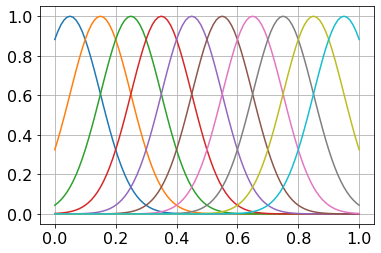

In [96]:
for i in range(M):
    plt.plot(x[0, :], phi(x, i)[0, :])
    
plt.grid()
plt.show()

# Dataset
Create the test data according to the description above.

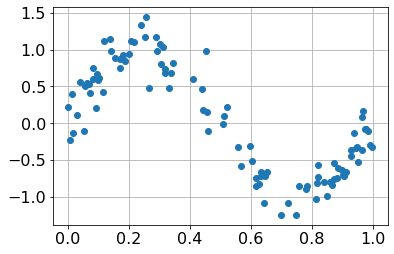

In [106]:
N = 100
beta = 25

xD = np.zeros((1, N))
yD = np.zeros((1, N))
for i in range(N):
    xD[0, i] = np.random.rand()
    yD[0, i] = np.sin(2 * np.pi * xD[0, i]) + np.random.normal(scale=np.sqrt(1/beta))
    
plt.plot(xD[0, :], yD[0, :], 'o')
plt.plot(x, np.sin(2*np.pi*x))
plt.grid()
plt.show()

# number of data points for the test runs
n_list = [10, 20, 50, 100]

# 1) Least squares fitting of the RBF model

In [107]:
# Function that delivers the weights w
def determine_w(x, y):
    return y @ np.linalg.pinv(Phi(x))

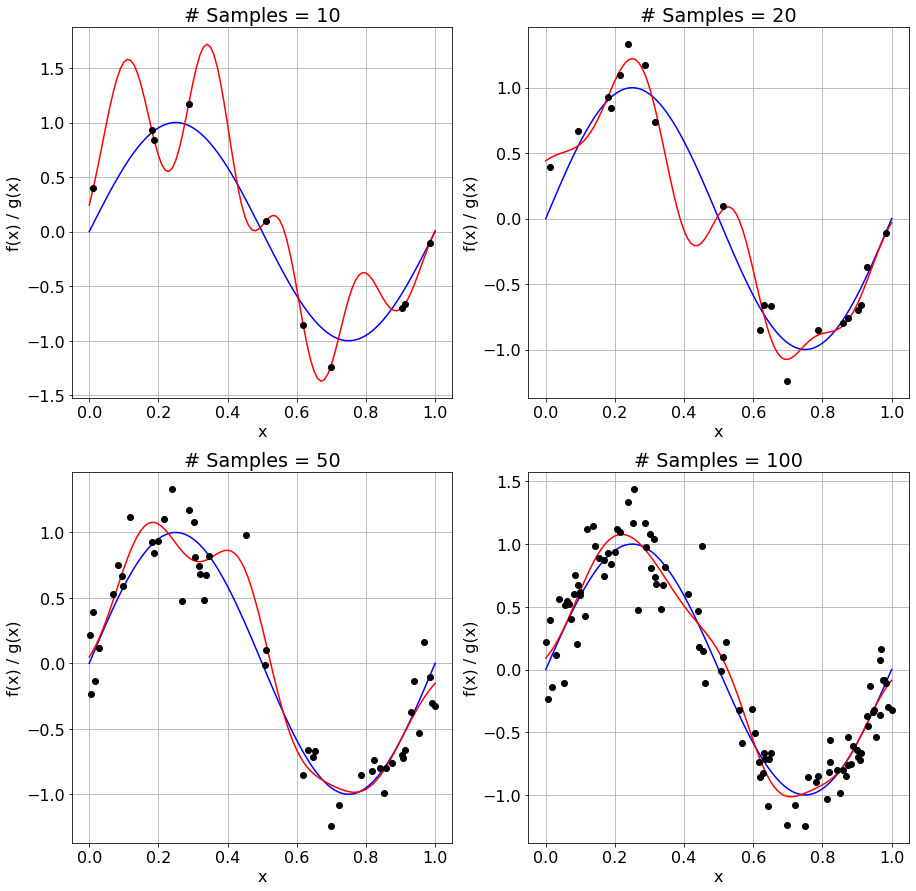

In [108]:
# plot least squares solution for various 
fig = plt.figure(figsize=[15, 15])
axs = list()
for i in range(4):
    
    # solve least squares for prescribed number of data points
    w = determine_w(xD[:, :n_list[i]], yD[:, :n_list[i]])
    
    axs.append(fig.add_subplot(2, 2, i + 1))
    plt.plot(x[0, :], np.sin(2*np.pi*x[0, :]), 'b-')
    plt.plot(x[0, :], g(x, w)[0, :], 'r-')
    axs[i].plot(xD[0, :n_list[i]], yD[0, :n_list[i]], 'ko')
    axs[i].grid()
    axs[i].set_title('# Samples = ' + str(n_list[i]))
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('f(x) / g(x)')
plt.show()

# 2) Maximum likelihood

In [109]:
def determine_sigma(x, y, w):
    N_ = x.shape[1]
    oneOverBeta = np.sum((g(x, w) - y)**2) / N_
    return np.sqrt(oneOverBeta)

7.930197099124211e-15
0.11258152810775661
0.1969678928975377
0.20291952212906944


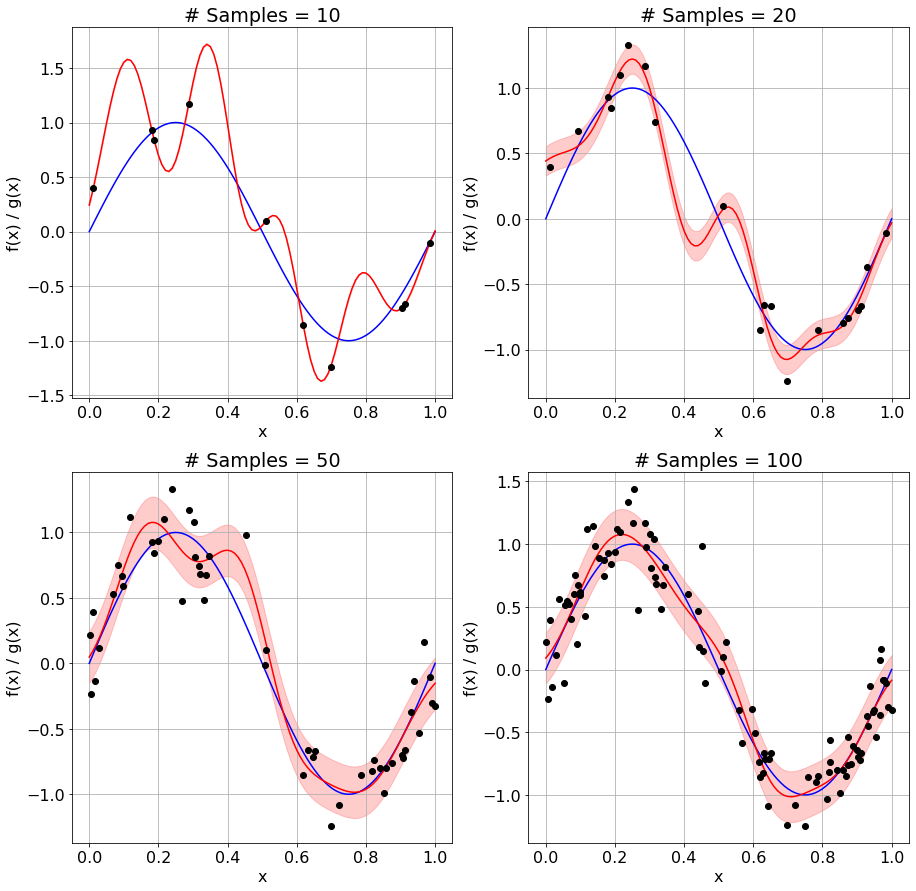

In [110]:
# plot least squares solution for various 
fig = plt.figure(figsize=[15, 15])
axs = list()
for i in range(4):
    
    # solve least squares for prescribed number of data points
    w = determine_w(xD[:, :n_list[i]], yD[:, :n_list[i]])
    sigma = determine_sigma(xD[:, :n_list[i]], yD[:, :n_list[i]], w)
    print(sigma)
    
    axs.append(fig.add_subplot(2, 2, i + 1))
    axs[i].fill_between(x[0, :], g(x, w)[0, :] - sigma, g(x, w)[0, :] + sigma, color='r', alpha=0.2)
    plt.plot(x[0, :], np.sin(2*np.pi*x[0, :]), 'b-')
    plt.plot(x[0, :], g(x, w)[0, :], 'r-')
    axs[i].plot(xD[0, :n_list[i]], yD[0, :n_list[i]], 'ko')
    axs[i].grid()
    axs[i].set_title('# Samples = ' + str(n_list[i]))
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('f(x) / g(x)')
plt.show()


# 3) Maximum likelihood with prior

In [117]:
def J(w, x, y, alpha, beta):
    return np.sum(np.power(g(x, w) - y[0, :], 2)) + alpha/beta * np.dot(w, w)

[[ 0.17024928  0.31268098  0.4333542   0.33492921  0.15494082 -0.11000472
  -0.430663   -0.4398445  -0.30707972 -0.13437928]] 0.20291952212906944
[[ 0.16413197  0.372053    0.52422946  0.32228085  0.12226057 -0.09564655
  -0.39030273 -0.44222629 -0.34557975 -0.12092262]] 0.20291952212906944
[[-0.01180962  0.54390934  0.42107508  0.23337063  0.29491135 -0.03637214
  -0.43380384 -0.47924172 -0.37151148 -0.067261  ]] 0.20291952212906944
[[-0.03940841  0.52026478  0.53650593  0.23498816  0.19873696 -0.05292919
  -0.45880953 -0.48265198 -0.39512148 -0.01673235]] 0.20291952212906944


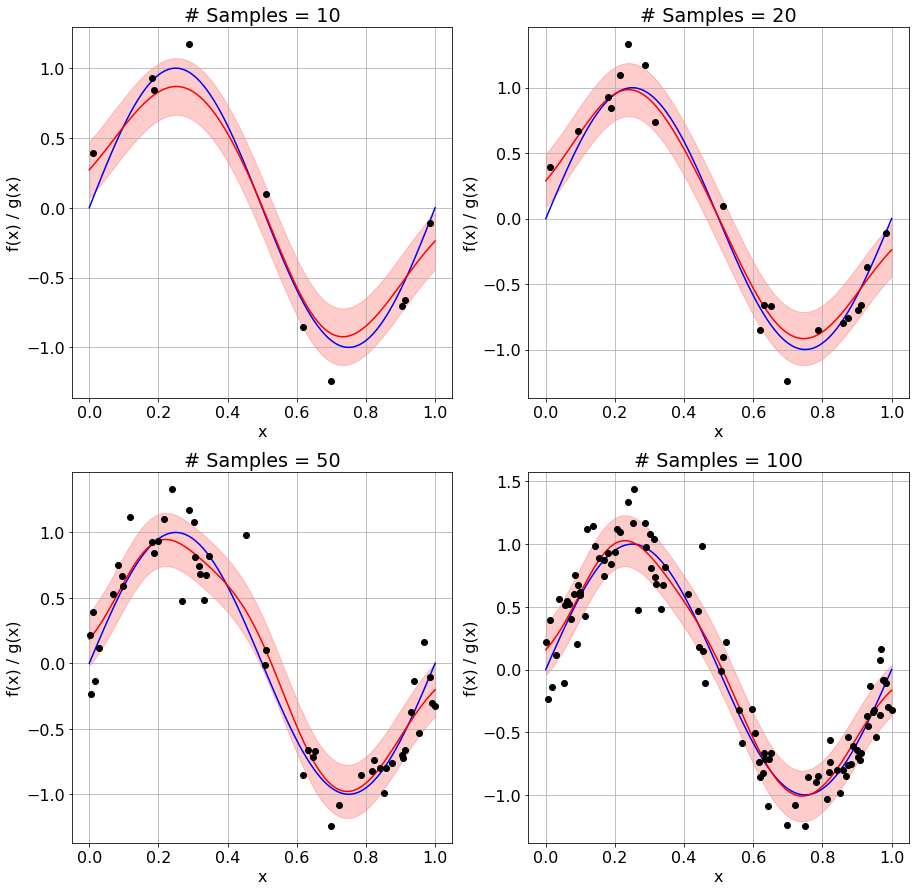

In [120]:
# precision of prior distribution
alpha = 25

beta = 1/sigma**2

# plot least squares solution for various 
fig = plt.figure(figsize=[15, 15])
axs = list()
for i in range(4):
    
    # solve least squares for prescribed number of data points
    w0 = np.random.rand(M)
    res = minimize(lambda w: J(w, xD[:, :n_list[i]], yD[:, :n_list[i]], alpha, beta), w0, method='BFGS')
    w = res.x[None, :]
    sigma = np.sqrt(1/beta)
    print(w, sigma)
    
    axs.append(fig.add_subplot(2, 2, i + 1))
    axs[i].fill_between(x[0, :], g(x, w)[0, :] - sigma, g(x, w)[0, :] + sigma, color='r', alpha=0.2)
    plt.plot(x[0, :], np.sin(2*np.pi*x[0, :]), 'b-')
    plt.plot(x[0, :], g(x, w)[0, :], 'r-')
    axs[i].plot(xD[0, :n_list[i]], yD[0, :n_list[i]], 'ko')
    axs[i].grid()
    axs[i].set_title('# Samples = ' + str(n_list[i]))
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('f(x) / g(x)')
plt.show()



# 4) Bayesian inference of the RBF model

## m and Sigma for increasing $N$

In [7]:
alpha = 1
m0 = np.zeros((M))
Sigma0 = 1/alpha * np.eye(M)

m = np.zeros((M, N + 1))
Sigma = np.zeros((M, M, N + 1))

m[:, 0] = m0
Sigma[:, :, 0] = Sigma0


for i in range(N):
    Sigma[:, :, i + 1] = np.linalg.inv(np.linalg.inv(Sigma[:, :, 0]) + beta * Phi(xD[:, :i+1]) @ Phi(xD[:, :i+1]).T)
    m[:, i + 1] = Sigma[:, :, i + 1] @ (np.linalg.inv(Sigma[:, :, 0]) @ m[:, i] + beta * (Phi(xD[:, :i+1]) @ yD[:, :i+1].T)[:,0])


## Prediction of $\mu$ and $\sigma$ for individual points $x$, as well as for the entire $x$ axis

In [8]:
def pred_mu(x, i):
    return np.dot(m[:, i], Phi(np.array([[x]])))

def pred_sig(x, i):
    PhiX = Phi(np.array([[x]]))
    return 1/beta + PhiX.T @ Sigma[:, :, i] @ PhiX

def pred_mu_sig(nData):
    mux = np.zeros(x.shape)
    sigx = np.zeros(x.shape)
    for i in range(x.shape[1]):
        mux[0, i] = pred_mu(x[0, i], nData)
        sigx[0, i] = pred_sig(x[0, i], nData)
    return mux, sigx

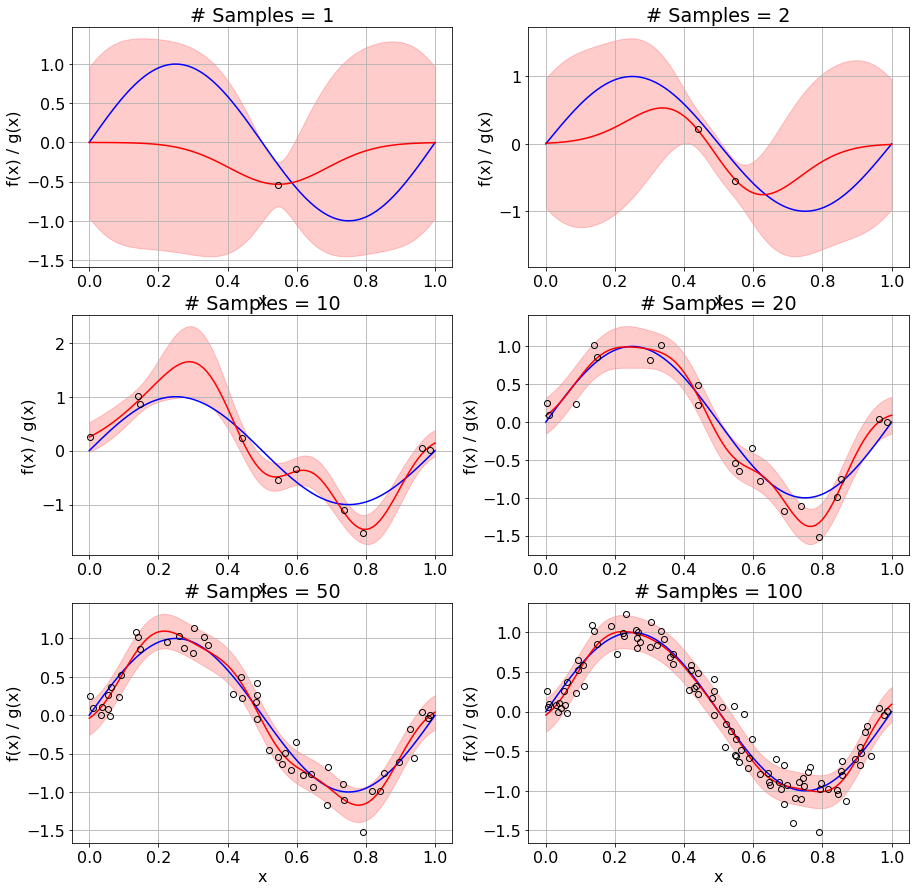

In [9]:
# plot expected value and standard deviation for various numbers of samples
n_list = [1, 2, 10, 20, 50, 100]

fig = plt.figure(figsize=[15, 15])
axs = list()
for i in range(6):
    
    mux, sigx = pred_mu_sig(n_list[i])
    
    axs.append(fig.add_subplot(3, 2, i + 1))
    axs[i].fill_between(x[0, :], mux[0, :] - np.sqrt(sigx[0, :]), mux[0, :] + np.sqrt(sigx[0, :]), color='r', alpha=0.2)
    axs[i].plot(x[0, :], np.sin(2*np.pi*x[0, :]), 'b-')
    axs[i].plot(x[0, :], mux[0, :], 'r-')
    #axs[i].plot(x[0, :], mux[0, :] + np.sqrt(sigx[0, :]), 'r--')
    #axs[i].plot(x[0, :], mux[0, :] - np.sqrt(sigx[0, :]), 'r--')
    axs[i].plot(xD[0, :n_list[i]], yD[0, :n_list[i]], 'ko', fillstyle='none')
    axs[i].grid()
    axs[i].set_title('# Samples = ' + str(n_list[i]))
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('f(x) / g(x)')
plt.show()